In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
from astropy import modeling
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
import scipy.signal as sig
import csv
import matplotlib
#from scipy.optimize import leasts
import os
import glob
from tqdm import tqdm
import gc
import scipy.stats as stats
from scipy.special import fdtr

In [8]:
## Burst Finding routine using Boxcar ##

def boxcar_kernel(width):
    """Returns the boxcar kernel of given width normalized by
    sqrt(width) for S/N reasons.

    Parameters
    ----------
    width : int
        Width of the boxcar.

    Returns
    -------
    boxcar : array_like
        Boxcar of width `width` normalized by sqrt(width).

    """
    width = int(round(width, 0))
    return np.ones(width, dtype="float32") / np.sqrt(width)
def find_burst(ts, width_factor=4, min_width=1, max_width=1024):
    """Find burst peak and width using boxcar convolution.

    Parameters
    ----------
    ts : array_like
        Time-series.
    width_factor : int, optional
        Windowing factor for on and off-pulse determination.
    min_width : int, optional
        Minimum width to search from, in number of time samples.
        1 by default.
    max_width : int, optional
        Maximum width to search up to, in number of time samples.
        128 by default.

    Returns
    -------
    peak : int
        Index of the peak of the burst in the time-series.
    width : int
        Width of the burst in number of samples.
    snr : float
        S/N of the burst.

    """
    min_width = int(min_width)
    max_width = int(max_width)

    # do not search widths bigger than timeseries
    widths = list(range(min_width,
                        min(max_width + 1, int((len(ts) - 50) // 6))))

    # envelope finding
    snrs = np.empty_like(widths, dtype=float)
    peaks = np.empty_like(widths, dtype=int)

    # borders for on and off-pulse determination
    outer = 3 * width_factor // 2
    inner = width_factor // 2

    for i in range(len(widths)):
        convolved = sig.convolve(ts, boxcar_kernel(widths[i]))
        peaks[i] = np.nanargmax(convolved)
        # peak should not be on the edge of time-series
        if (peaks[i] > 0.999 * ts.shape[0]) or (peaks[i] < 0.001 * ts.shape[0]):
            snrs[i] = np.nan
        else:
            # get RMS for S/N weighting, as in PRESTO's single_pulse_search.py
            baseline = np.concatenate(
                [
                    convolved[0 : max(0, peaks[i] - 3 * widths[i])],
                    convolved[peaks[i] + 3 * widths[i] :],
                ]
            )

            # cutoff of at least 50 samples is a bit arbitrary, but seems
            # reasonable
            if baseline.shape[0] > 50:
                rms = np.std(baseline)
            else:
                rms = np.nan

            snrs[i] = convolved[peaks[i]] / rms

    best_idx = np.nanargmax(snrs)

    return peaks[best_idx]-widths[best_idx]//2, widths[best_idx], snrs[best_idx]

def scrunch_npy(npy_fil, f_scrunch=1, t_scrunch=1):
    '''
    Scrunch data in frequency and time.
    '''
    
    ### Add cases when t_scrunch doesn't divide exactly ####
    data = npy_fil
    if (data.shape[1] % t_scrunch) == 0:
        data = data.reshape([data.shape[0] // f_scrunch, f_scrunch, data.shape[1]]).mean(axis=1)
        data = data.reshape([data.shape[0], data.shape[1] // t_scrunch, t_scrunch]).mean(axis=-1)
    else:
        t_range = data.shape[1] - (data.shape[1] % t_scrunch) ### Make the number divisible by subtrating remainder
        print("Time range adjusted for scrunching", t_range)
        data = data[:,:t_range]
        data = data.reshape([data.shape[0] // f_scrunch, f_scrunch, data.shape[1]]).mean(axis=1)
        data = data.reshape([data.shape[0], data.shape[1] // t_scrunch, t_scrunch]).mean(axis=-1)
    return data

def shift(v, i, nchan):
        """                                                                                                                                                            
        function v by a shift i                                                                                                                                        
        nchan is the number of frequency channels (to account for negative lag)                                                                                        
        """
        n = len(v)
        r = np.zeros(3*n)
        i+=nchan-1 #to account for negative lag                                                                                                                        
        i = int(i)
        r[i:i+n] = v
        return r

def autocorr(x, v=None,zerolag=False):
    """
    compute the autocorrelation function of x 
    if x has flagged values give those as an array of 1s (no mask) and 0 (mask): v
    if you wish to zap the zero lag spike, use zerolag=False, else zerolag=True
    """
    n=len(x)
    if v is None:
        v = np.ones_like(x)
    x = x.copy()
    x[v!=0] -= x[v!=0].mean()
    ACF = np.zeros_like(x)
    for i in tqdm(range(n)):
        if zerolag == False:
                if i>0:
                        m = shift(v,0,n)*shift(v,i,n)
                        ACF[i-1] = np.sum(shift(x,0,n)*shift(x, i,n)*m)/np.sqrt(np.sum(shift(x, 0, n)**2*m)*np.sum(shift(x, i, n)**2*m))
        else:
                m = shift(v,0,n)*shift(v,i,n)
                ACF[i] = np.sum(shift(x,0,n)*shift(x, i,n)*m)/np.sqrt(np.sum(shift(x, 0, n)**2*m)*np.sum(shift(x, i, n)**2*m))
            

    return ACF

def plot_acf(acf, acf1d, ts, acf_zero ,event, ds, full_acf = False, save_fig=False):
    
    fig, ax = plt.subplots(2, 2, figsize = (15,5))
    t_res = ds * 2.56
    e = event


    fig.suptitle("Time series ACF of event {} at a time resolution of {} microseconds".format(e,t_res))
    
    x_ts = t_res*np.arange(ts.size)
    
    x = t_res*np.arange(acf.size)
    x_zero = t_res*np.arange(acf_zero.size)
    x1d = t_res*np.arange(acf1d.size)
    
    if full_acf:
        x = x - np.median(x)
        x_zero = x_zero - np.median(x_zero)
        x1d = x1d - np.median(x1d)

    ax[0][0].plot(x_ts, ts)
    ax[0][0].set_xlabel("Microsecond")
    ax[0][1].plot(x, acf)
    ax[0][1].set_xlabel("Lag (microsecond)")

    ax[1][0].plot(x1d, acf1d, label = e)
    ax[1][0].legend()
    ax[1][0].set_xlabel("Lag (microsecond)")
    ax[1][1].plot(x_zero, acf_zero)
    ax[1][1].set_xlabel("Lag (microsecond)")

    if save_fig:
        oname = "Microstructures/Microstruc_{}_v2.jpeg".format(e)
        print(oname)
        plt.savefig(oname, dpi = 300, bbox_inches = 'tight')

    fig.show()
    gc.collect()
    
def add_flip(acf):
    acf_rev = np.flip(acf)
    acf_comb = np.concatenate((acf_rev, acf))
    
    return acf_comb

##### Trying Lorentzian Fit ######

def lorentzian( x, a, x0, gam ):
    return  a * gam**2 / ( gam**2 + ( x - x0 )**2)


def chi_sq(obs, exp):
    if len(obs) == len(exp):
        chi_sq = 0
        for i in range(len(obs)):
            x = ((obs[i]-exp[i])**2)/exp[i]
            chi_sq = chi_sq+x
    else:
        print("The length of observation and expected not same")
        
    return chi_sq




def compute_test_f(chisq_1: float, chisq_2: float, num_fit_parameters_1: int,
    num_fit_parameters_2: int, num_observations_1: int, num_observations_2: int) -> float:
    """
    Computes the statistical 'F' test value for comparing best-fit fitburst models.
    Parameters
    ----------
    chisq_1 : float
        The best-fit, chi-squared value for fitburst model #1
    chisq_2 : float
        The best-fit, chi-squared value for fitburst model #2
    num_fit_parameters_1 : float
        The number of fitted parameters for fitburst model #1
    num_fit_parameters_2 : float
        The number of fitted parameters for fitburst model #2
    num_observations_1 : float
        The number of data points used for fitburst model #1
    num_observations_2 : float
        The number of data points used for fitburst model #2
    Returns
    -------
    f_test : float
        The F-test (chance coincidence probability) value.
    """

    # pylint: disable=too-many-arguments

    # compute various terms needed for F-test calc.
    delta_chisq = chisq_2 - chisq_1
    deg_freedom_1 = num_observations_1 - num_fit_parameters_1
    deg_freedom_2 = num_observations_2 - num_fit_parameters_2
    delta_deg_freedom = deg_freedom_2 - deg_freedom_1
    chisq_reduced_2 = chisq_2 / deg_freedom_2
    probability = 1.

    # now compute the F-test statistic.
    if delta_chisq > 0.:
        f_value = delta_chisq / delta_deg_freedom / chisq_reduced_2
        f_stat = fdtr(delta_deg_freedom, deg_freedom_2, f_value)
        probability -= f_stat

    return probability



In [9]:
##### Load data files ######
basepath = '/data/user-data/ksand/R3/fitburst_run_final/'
entries = os.listdir(basepath)
entries.remove('.ipynb_checkpoints')
entries = np.array(entries).astype(int)
entries = np.sort(entries)
print(entries)


basepath = '/data/user-data/ksand/R3/fitburst_run_final/'
event_ids = []
pm_files = []
result_files = []
input_files = []
summary = []
for event in entries:
    if (event != '.ipynb_checkpoints'): 
        path_to_event = os.path.join(basepath, str(event))
        trials = np.array(os.listdir(path_to_event))
        count = 0


        for trial in trials:
            if (trial != '.ipynb_checkpoints'):
                path_to_file = os.path.join(path_to_event, trial)
                event_ids.append(event)
                np.array(pm_files.append(glob.glob(path_to_file + '/pm*.npz')))
                np.array(result_files.append(glob.glob(path_to_file + '/result*.npz')))
                np.array(input_files.append(glob.glob(path_to_file + '/R3*.npz')))
                np.array(summary.append(glob.glob(path_to_file + '/summary*.png')))
                count = count + 1

[ 23789294  23891929  40363753  40750224  40750656  60073678  65395717
  65511496  67522832  67522901  69509443  71665813  71784400  71784833
  71785167  73726599  83984528  84081108  92773515  92844954 135577833
 151677988 153859596 154910364 154913824 155079679 163181014 163362088
 163534005 166812476 171681248 171855709 175004577 175929272 176060009
 180666196 180667327 188553320 194488374 194488393 194488454 195132396
 200973875 203798724 203935225]


In [10]:
###### Combine them all to one file ######
npz_files = []
for pm_file, event, input_file in zip(pm_files,event_ids,input_files):
    npz_files.append(event)
    
    data_input = np.load(input_file[0], allow_pickle = True)
    input_npz = data_input['data_full']
    npz_files.append(input_npz)
    
    data_pm = np.load(pm_file[0], allow_pickle = True)
    ds = data_pm['arr_0'].item(0)['ds']
    npz_files.append(ds)
    


23789294
Downsample in micro sec 81.92


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 14860.08it/s]


$$$$$$$$$$Now getting the Noise!!!!!!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 17494.49it/s]


23891929
Downsample in micro sec 40.96


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 528/528 [00:00<00:00, 13629.44it/s]


$$$$$$$$$$Now getting the Noise!!!!!!


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 13990.12it/s]


40363753
Downsample in micro sec 40.96


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 721/721 [00:00<00:00, 12953.70it/s]


$$$$$$$$$$Now getting the Noise!!!!!!


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:00<00:00, 14894.48it/s]


92773515
Downsample in micro sec 81.92


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 208/208 [00:00<00:00, 14484.01it/s]


$$$$$$$$$$Now getting the Noise!!!!!!


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 12483.42it/s]


92844954
Downsample in micro sec 40.96


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 601/601 [00:00<00:00, 12378.78it/s]


$$$$$$$$$$Now getting the Noise!!!!!!


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 146/146 [00:00<00:00, 13945.35it/s]


166812476
Downsample in micro sec 81.92


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 246/246 [00:00<00:00, 13940.40it/s]


$$$$$$$$$$Now getting the Noise!!!!!!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 96/96 [00:00<00:00, 13276.62it/s]


176060009
Downsample in micro sec 2.56


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1206/1206 [00:00<00:00, 9855.16it/s]


$$$$$$$$$$Now getting the Noise!!!!!!


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 13543.76it/s]


194488393
Downsample in micro sec 10.24


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:00<00:00, 4959.57it/s]


$$$$$$$$$$Now getting the Noise!!!!!!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1132/1132 [00:00<00:00, 10301.08it/s]


194488454
Downsample in micro sec 10.24


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 889/889 [00:00<00:00, 11358.40it/s]


$$$$$$$$$$Now getting the Noise!!!!!!


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 347/347 [00:00<00:00, 14560.93it/s]


203935225
Downsample in micro sec 20.48


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:00<00:00, 9307.77it/s]


$$$$$$$$$$Now getting the Noise!!!!!!


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 526/526 [00:00<00:00, 13181.99it/s]


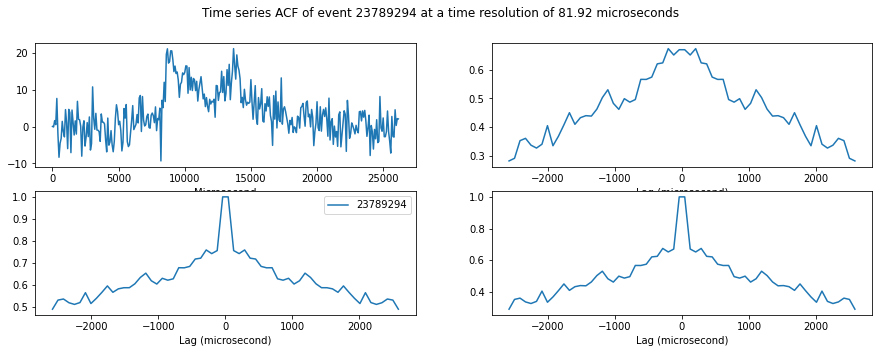

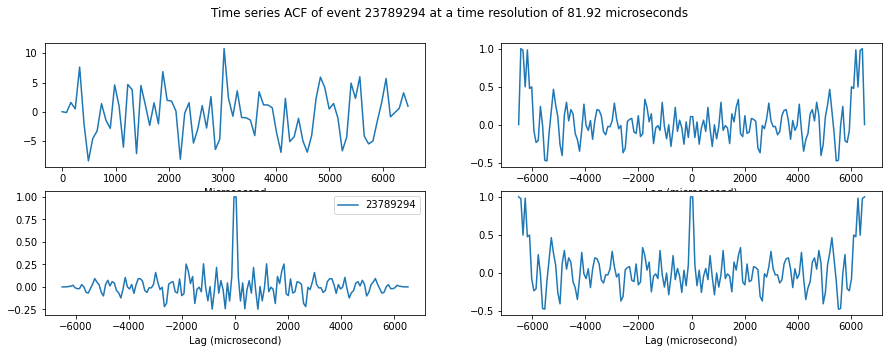

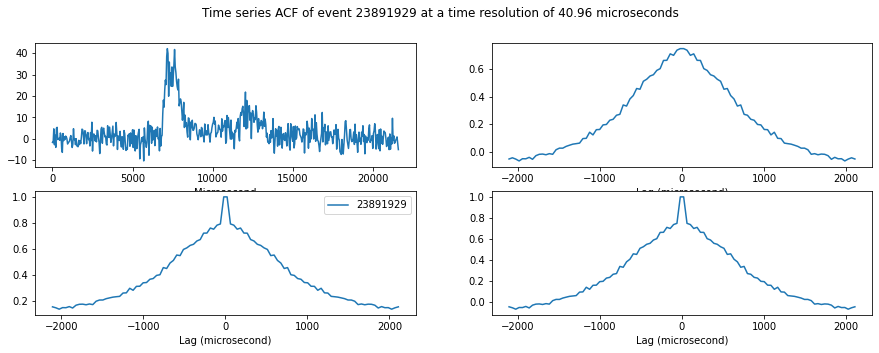

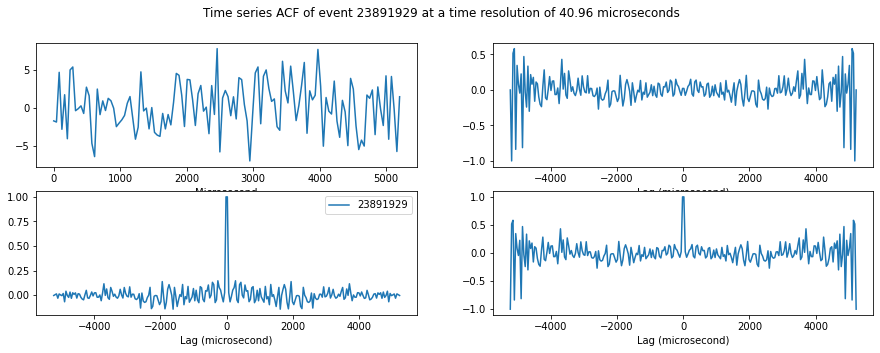

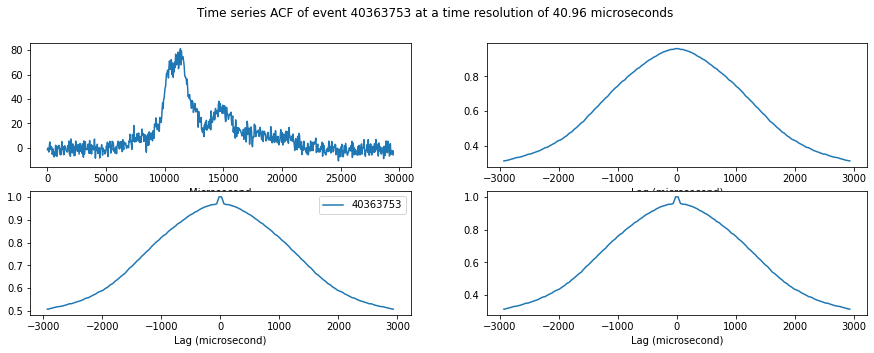

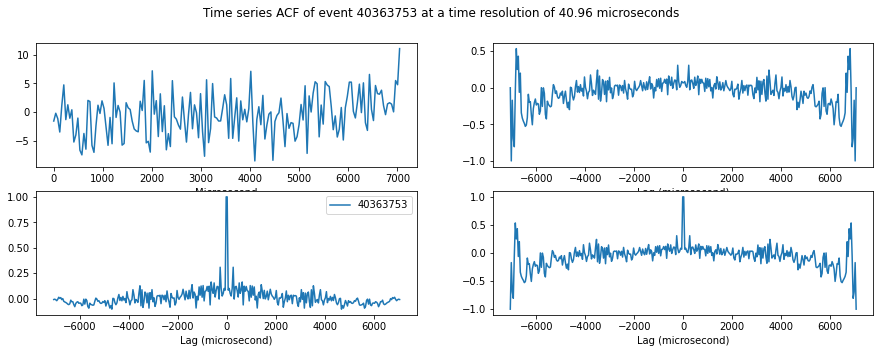

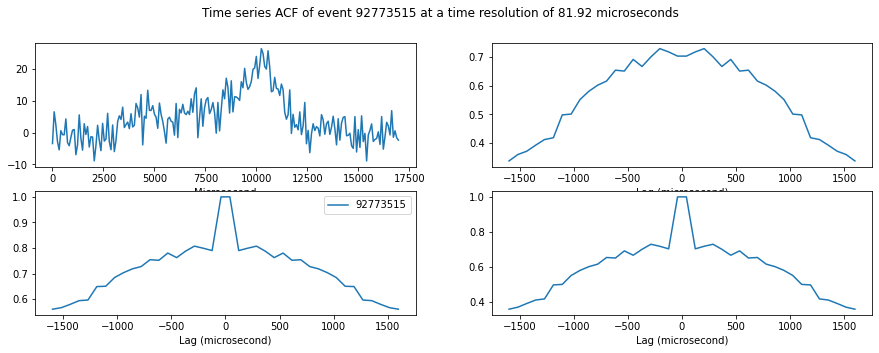

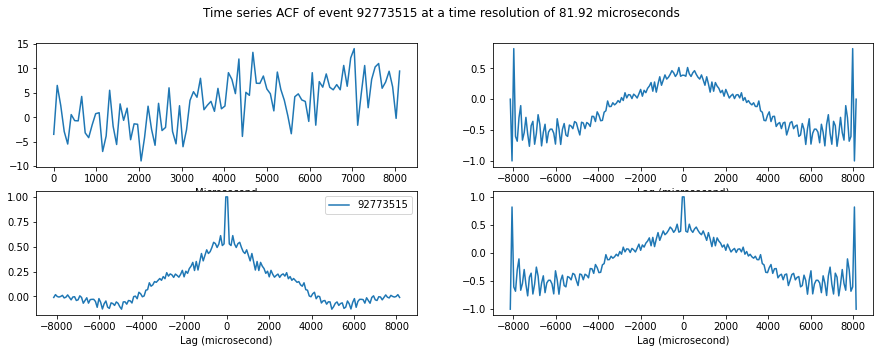

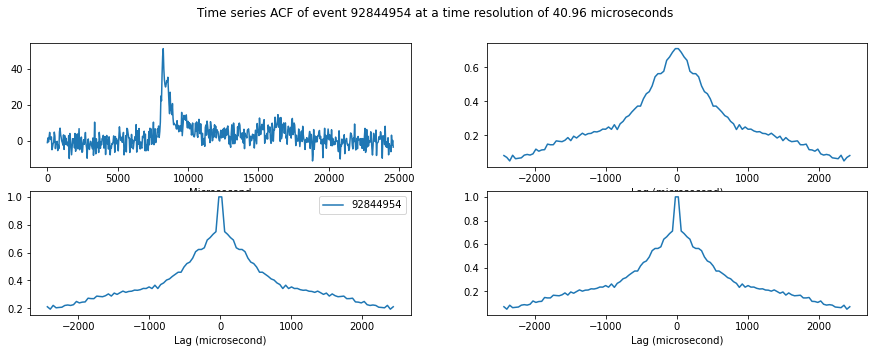

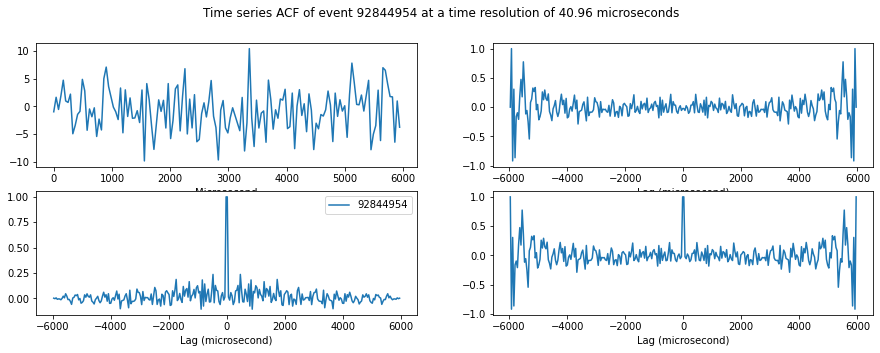

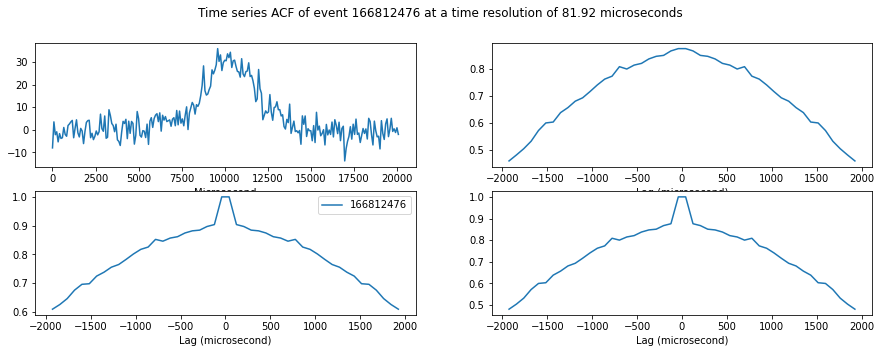

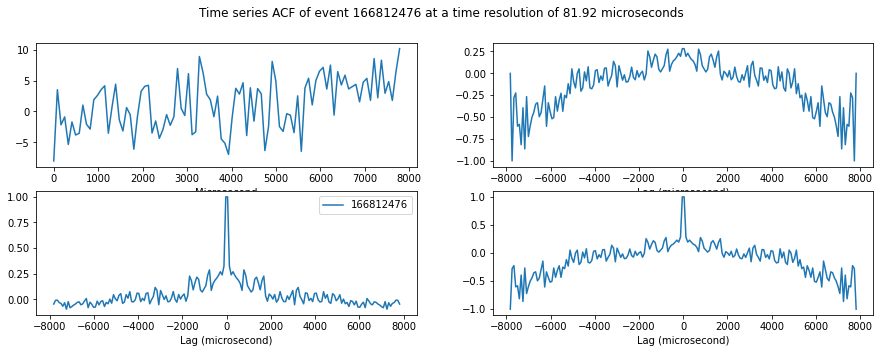

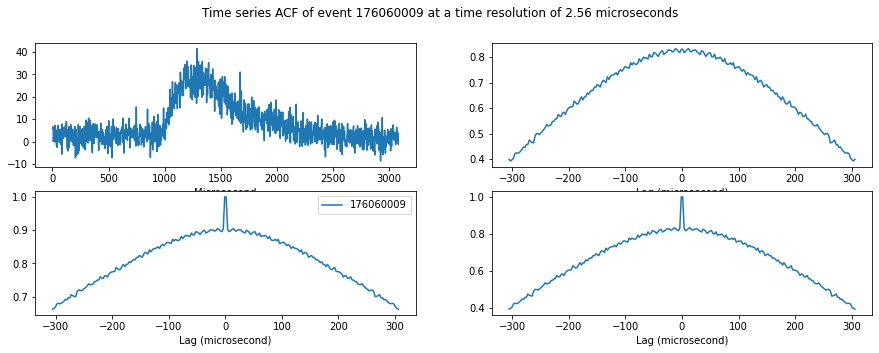

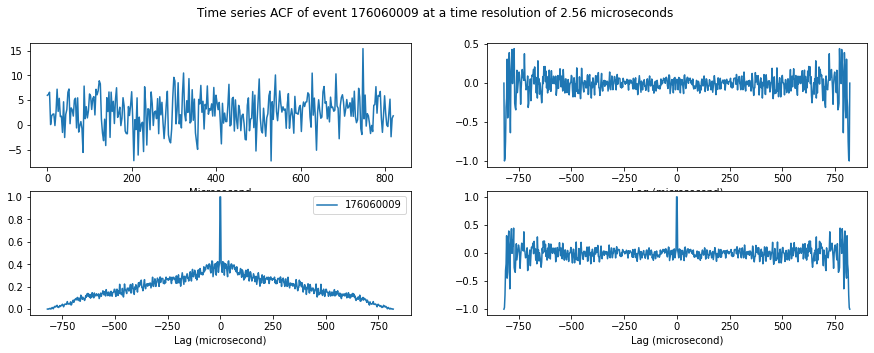

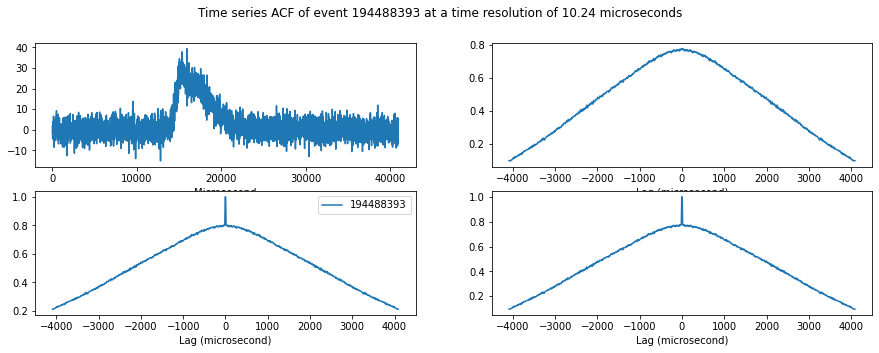

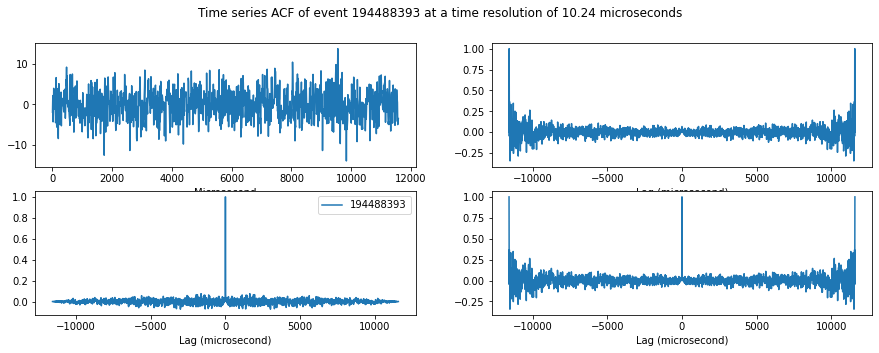

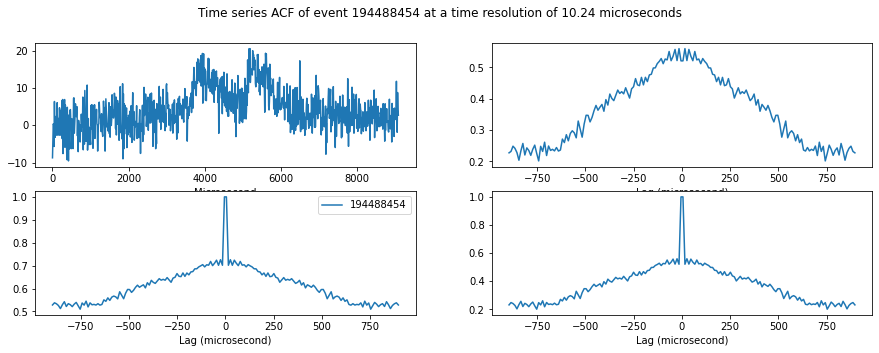

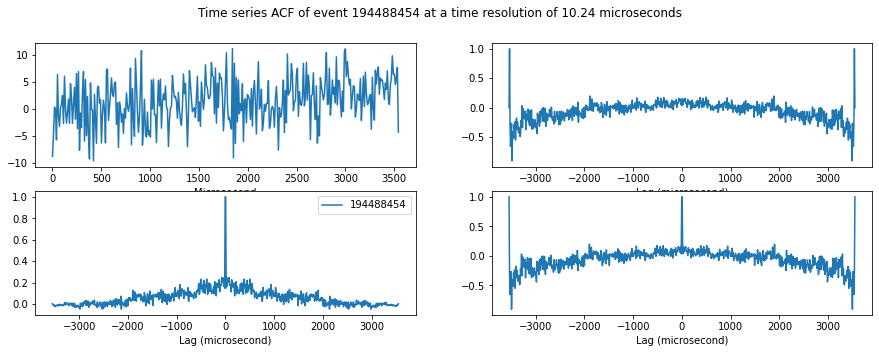

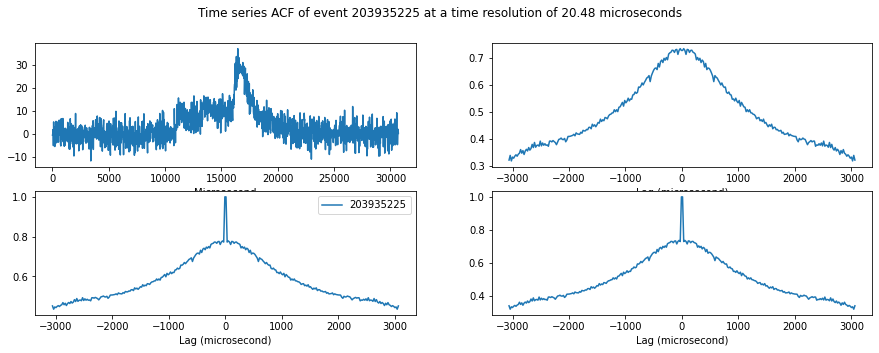

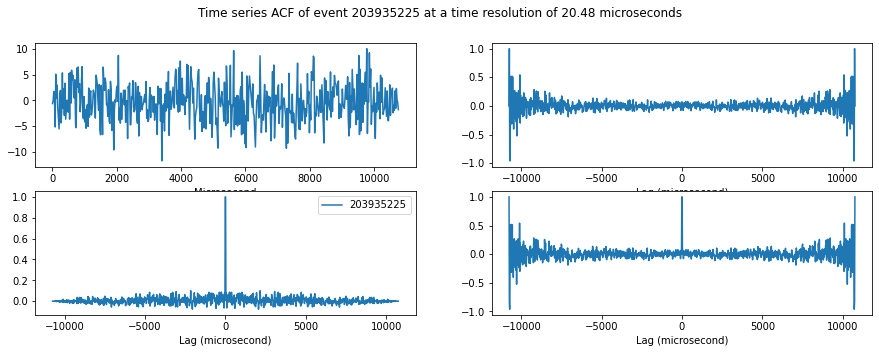

In [8]:
event = 40363753
for i in range(0, len(npz_files),3):
    #if int(npz_files[i]) == int(event):
    if (npz_files[i+2] < 64) and (int(npz_files[i]) != 71785167):
        e = npz_files[i]
        print(e)

        
        data = npz_files[i+1]
        
        t_scrunch = 1
        f_scrunch = 8
        data = scrunch_npy(data, f_scrunch=f_scrunch, t_scrunch=t_scrunch)
        
        ds = npz_files[i+2]
        print("Downsample in micro sec", ds*2.56)
        ts = data.sum(0)
        acf_zero = autocorr(ts, zerolag=True)
        acf = autocorr(ts, zerolag=False)
        acf1d = sig.correlate(ts, ts)
        acf1d = acf1d/np.max(acf1d)
        acf1d = acf1d[int(len(acf1d)/2):]
        #plot_acf(acf, acf1d, ts, acf_zero, e, ds)
        
        ###### Getting the full acf by flipping and adding ########

        acf = add_flip(acf)
        acf_zero  = add_flip(acf_zero)
        acf1d = add_flip(acf1d)
        
        ##### To get the acf near the peak #####
        
        nsamp = int(len(ts)/10)
        
        acf = acf[int(len(acf)/2)-nsamp:int(len(acf)/2)+nsamp]
        acf1d = acf1d[int(len(acf1d)/2)-nsamp:int(len(acf1d)/2)+nsamp]
        acf_zero = acf_zero[int(len(acf_zero)/2)-nsamp:int(len(acf_zero)/2)+nsamp]
        
        ##### Plotting #########

        plot_acf(acf, acf1d, ts, acf_zero, e, ds, True)
        
        ####### Noise ACF ######
        print("$$$$$$$$$$Now getting the Noise!!!!!!")
        peaks, widths, snrs = find_burst(ts, max_width=8192)
        if (peaks+widths) < len(ts) and (peaks-widths) > 0:
            start_noise = 0
            end_noise = int(peaks - widths)
        else:
            print("Burst too wide can't find noise")
            
        ts_noise = ts[start_noise:end_noise]
        acf_zero_noise = autocorr(ts_noise, zerolag=True)
        acf_noise = autocorr(ts_noise, zerolag=False)
        acf1d_noise = sig.correlate(ts_noise, ts_noise)
        acf1d_noise = acf1d_noise/np.max(acf1d_noise)
        acf1d_noise = acf1d_noise[int(len(acf1d_noise)/2):]
        #plot_acf(acf, acf1d, ts, acf_zero, e, ds)
        
        ###### Getting the full acf by flipping and adding ########

        acf_noise = add_flip(acf_noise)
        acf_zero_noise  = add_flip(acf_zero_noise)
        acf1d_noise = add_flip(acf1d_noise)
        
        ##### Plotting ######
        
        plot_acf(acf_noise, acf1d_noise, ts_noise, acf_zero_noise, e, ds, True)


92844954


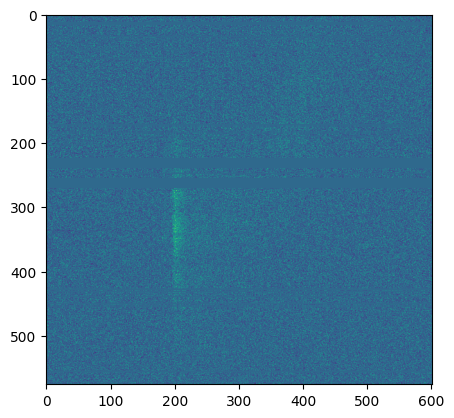

Downsample in micro sec 40.96


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:00<00:00, 16274.77it/s]

24
149.0
[0.7894509406636879, 24, 12]
0.7471517151683088 23.49999999779263 15.322213118306768
(48,) (48,)
0.04011411390203645
[0.04309399938563574, 4, 2]
0.05397121959709557 4.518579368452627 1.0431958528513599
Width of microstructure 42.7293021327917 $\mu$s
Microstructures/Microstruc_92844954.pdf


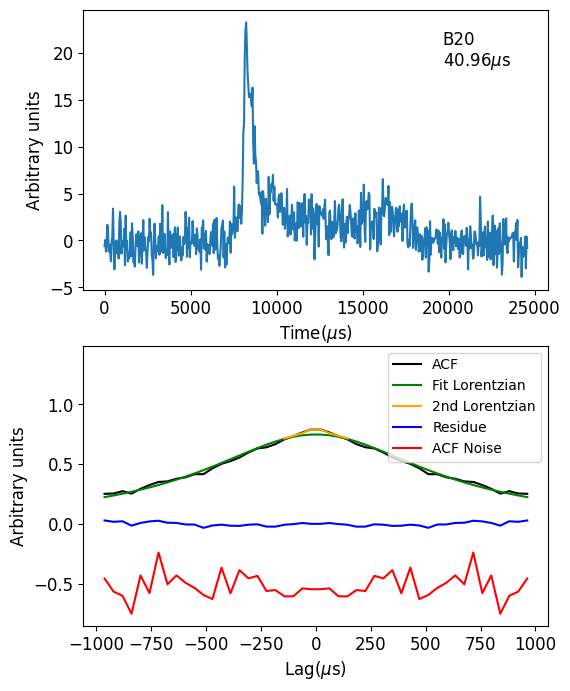

In [13]:
####### Fitting Lorentzian adding Noise and plotting ########

event = 92844954
for i in range(0, len(npz_files),3):
    if int(npz_files[i]) == int(event):
    #if (npz_files[i+2] < 64) and (int(npz_files[i]) != 71785167):
        e = npz_files[i]
        print(e)
        data = npz_files[i+1]
        data = data[200:776,:]
        plt.imshow(data)
        plt.show()
        t_scrunch = 1
        f_scrunch = 16
        data = scrunch_npy(data, f_scrunch=f_scrunch, t_scrunch=t_scrunch)
        
        
        ds = npz_files[i+2]
        print("Downsample in micro sec", ds*2.56)
        t_res = ds*2.56
        ts = data.sum(0)
        acf_zero = autocorr(ts, zerolag=True)
        acf = autocorr(ts, zerolag=False)
        acf1d = sig.correlate(ts, ts)
        acf1d = acf1d/np.max(acf1d)
        acf1d = acf1d[int(len(acf1d)/2):]
        #plot_acf(acf, acf1d, ts, acf_zero, e, ds)
        
        ###### Getting the full acf by flipping and adding ########

        acf = add_flip(acf)
        acf_zero  = add_flip(acf_zero)
        acf1d = add_flip(acf1d)
                
        ##### To get the acf near the peak #####
        
        nsamp = int(len(ts)/25)
        
        acf = acf[int(len(acf)/2)-nsamp:int(len(acf)/2)+nsamp]
        acf1d = acf1d[int(len(acf1d)/2)-nsamp:int(len(acf1d)/2)+nsamp]
        acf_zero = acf_zero[int(len(acf_zero)/2)-nsamp:int(len(acf_zero)/2)+nsamp]
        
        ##### Plotting #########

        #plot_acf(acf, acf1d, ts, acf_zero, e, ds, True)
         
        ####### Noise ACF ######
        peaks, widths, snrs = find_burst(ts, max_width=8192)
        if (peaks+widths) < len(ts) and (peaks-widths) > 0:
            start_noise = 0
            end_noise = int(peaks - widths)
        else:
            print("Burst too wide can't find noise")
            
        ts_noise = ts[start_noise:end_noise]
        acf_zero_noise = autocorr(ts_noise, zerolag=True)
        acf_noise = autocorr(ts_noise, zerolag=False)
        acf1d_noise = sig.correlate(ts_noise, ts_noise)
        acf1d_noise = acf1d_noise/np.max(acf1d_noise)
        acf1d_noise = acf1d_noise[int(len(acf1d_noise)/2):]
        #plot_acf(acf, acf1d, ts, acf_zero, e, ds)
        
        ###### Getting the full acf by flipping and adding ########

        acf_noise = add_flip(acf_noise)
        acf_zero_noise  = add_flip(acf_zero_noise)
        acf1d_noise = add_flip(acf1d_noise)
        
        ###### Making the noise acf same size as burst acf ########
        
        nsamp = int(len(acf)/2)
        print(nsamp)
        print(len(acf_noise)/2)
        acf_noise = acf_noise[int(len(acf_noise)/2)-nsamp:int(len(acf_noise)/2)+nsamp]
        acf1d_noise = acf1d_noise[int(len(acf1d_noise)/2)-nsamp:int(len(acf1d_noise)/2)+nsamp]
        acf_zero_noise = acf_zero_noise[int(len(acf_zero_noise)/2)-nsamp:int(len(acf_zero_noise)/2)+nsamp]
        
        #plot_acf(acf_noise, acf1d_noise, ts_noise, acf_zero_noise, e, ds, True)
        
        ##### Adding Lorentzian #####
        
        ydata = acf

        x = np.arange(0,len(ydata))

        a_guess = np.max(ydata)
        x0_guess = int(len(ydata)/2)
        gam_guess = int(len(ydata)/4)

        pguess = [a_guess, x0_guess, gam_guess]
        print(pguess)
        popt, pcov = curve_fit(lorentzian, x, ydata, p0 = np.array(pguess))

        amp, x0, gam = popt[0], popt[1], popt[2]
        print(amp, x0, gam)

        yfit = lorentzian(x,amp,x0, gam)
        
        print(ydata.shape, yfit.shape)
        
        chi1 =  chi_sq(ydata,yfit) 
        num_para1 = len(pguess)
        num_obs1 = len(ydata)
        print(chi1)
        
        ### Second Lorentzian #####
        
        if int(npz_files[i]) == 92844954:
        
            yleft = ydata - yfit
            yleft=yleft[int(x0-gam/4):int(x0+gam/4)]


            if len(yleft) <= 2:
                print("Nothing to fit here")

            x2 = np.arange(0,len(yleft))

            a_guess2 = np.max(yleft)
            x0_guess2 = int(len(yleft)/2)
            gam_guess2 = int(len(yleft)/4)

            pguess2 = [a_guess2, x0_guess2, gam_guess2]
            print(pguess2)
            popt2, pcov2 = curve_fit(lorentzian, x2, yleft, p0 = np.array(pguess2))

            amp2, x02, gam2 = popt2[0], popt2[1], popt2[2]
            print(amp2, x02, gam2)
            
            print(r"Width of microstructure {} $\mu$s".format(gam2*t_res))

            lor_combine = lorentzian(x,amp,x0, gam)+lorentzian(x,amp2,x0, gam2)


        
        fig, ax = plt.subplots(2, figsize = (6,8))
        
        t_res = ds * 2.56
        xp = t_res*np.arange(acf.size)
        xp = xp - np.median(xp)
        xts = t_res*np.arange(ts.size)
        
        
        
        ax[0].plot(xts, ts,)
        ax[0].set_xlabel(r"Time($\mu$s)", fontsize=12)
        ax[0].set_ylabel("Arbitrary units", fontsize=12)
        ax[0].text(np.max(xts)-np.max(xts)/5,np.max(ts)-np.max(ts)/10, 'B'+str(int(i/3)+1), fontsize=12)#### Replaced with B number##
        ax[0].text(np.max(xts)-np.max(xts)/5,np.max(ts)-2*np.max(ts)/10, str(t_res)+r"$\mu$s", fontsize=12)
        ax[0].tick_params(axis='both', which='major', labelsize=12)

        
        ax[1].plot(xp, acf, color='k', label='ACF')
        ax[1].plot(xp, lorentzian(x,amp,x0, gam), 'g', label="Fit Lorentzian")
        if int(npz_files[i]) == 92844954:
            ax[1].plot(xp[int(x0-3*gam2):int(x0+3*gam2)+2],
                       lor_combine[int(x0-3*gam2):int(x0+3*gam2)+2], 'orange', label='2nd Lorentzian')
            ax[1].plot(xp,acf - lor_combine, 'b', label="Residue")
        else:
            ax[1].plot(xp,acf - lorentzian(x,amp,x0, gam), 'b', label="Residue")
        ax[1].plot(xp,acf_noise-0.5, color='r', label="ACF Noise")
        ax[1].set_xlabel(r"Lag($\mu$s)", fontsize=12)
        ax[1].set_ylabel("Arbitrary units", fontsize=12)
        ax[1].legend(loc="upper right")
        ax[1].set_ylim(np.min(acf_noise-0.5)-0.1,np.max(acf)+0.7)
        ax[1].tick_params(axis='both', which='major', labelsize=12)
        oname = "Microstructures/Microstruc_{}.pdf".format(e)
        print(oname)
        #plt.savefig(oname, dpi = 300, bbox_inches = 'tight')
        plt.show()
        
        
        

92844954
Downsample in micro sec 40.96


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 146/146 [00:00<00:00, 18681.16it/s]

24
146.0
[0.7110041023614122, 24, 12]
0.6666037462945944 23.500000000045258 15.534339685071878
[0.7110041023614122, 0.07110041023614122, 24, 12, 1.2]
0.4655099058862695 0.2383707826652404 23.499999999170893 21.014756758922164 6.508423042597281
0.024718870887081877
Microstructures/Microstruc_92844954.pdf


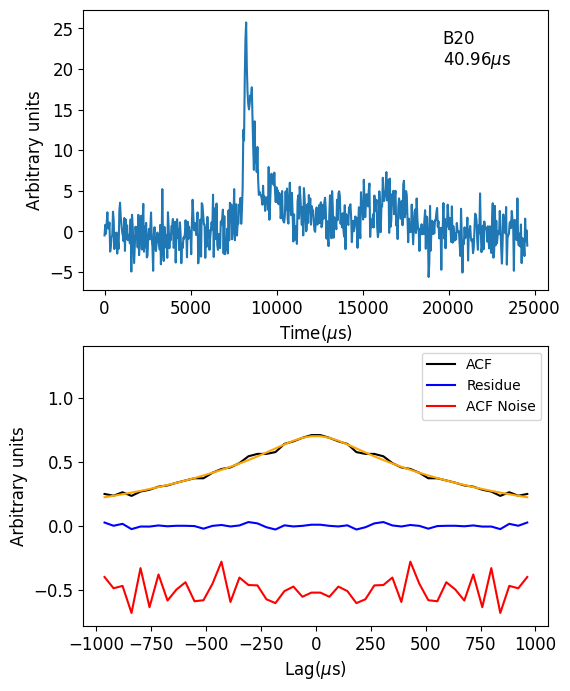

In [13]:
####### Fitting two lorentzian for 92844954 simultaneously ######

def two_lorentzian(x,amp,amp2,x0,gam,gam2):
    lor_combine = lorentzian(x,amp,x0, gam)+lorentzian(x,amp2,x0, gam2)
    return lor_combine

event = 92844954
for i in range(0, len(npz_files),3):
    if int(npz_files[i]) == int(event):
    #if (npz_files[i+2] < 64) and (int(npz_files[i]) != 71785167):
        e = npz_files[i]
        print(e)
        data = npz_files[i+1]
        
        t_scrunch = 1
        f_scrunch = 16
        data = scrunch_npy(data, f_scrunch=f_scrunch, t_scrunch=t_scrunch)        
        
        ds = npz_files[i+2]
        print("Downsample in micro sec", ds*2.56)
        ts = data.sum(0)
        acf_zero = autocorr(ts, zerolag=True)
        acf = autocorr(ts, zerolag=False)
        acf1d = sig.correlate(ts, ts)
        acf1d = acf1d/np.max(acf1d)
        acf1d = acf1d[int(len(acf1d)/2):]
        #plot_acf(acf, acf1d, ts, acf_zero, e, ds)
        
        ###### Getting the full acf by flipping and adding ########

        acf = add_flip(acf)
        acf_zero  = add_flip(acf_zero)
        acf1d = add_flip(acf1d)
                
        ##### To get the acf near the peak #####
        
        nsamp = int(len(ts)/25)
        
        acf = acf[int(len(acf)/2)-nsamp:int(len(acf)/2)+nsamp]
        acf1d = acf1d[int(len(acf1d)/2)-nsamp:int(len(acf1d)/2)+nsamp]
        acf_zero = acf_zero[int(len(acf_zero)/2)-nsamp:int(len(acf_zero)/2)+nsamp]
        
        ##### Plotting #########

        #plot_acf(acf, acf1d, ts, acf_zero, e, ds, True)
         
        ####### Noise ACF ######
        peaks, widths, snrs = find_burst(ts, max_width=8192)
        if (peaks+widths) < len(ts) and (peaks-widths) > 0:
            start_noise = 0
            end_noise = int(peaks - widths)
        else:
            print("Burst too wide can't find noise")
            
        ts_noise = ts[start_noise:end_noise]
        acf_zero_noise = autocorr(ts_noise, zerolag=True)
        acf_noise = autocorr(ts_noise, zerolag=False)
        acf1d_noise = sig.correlate(ts_noise, ts_noise)
        acf1d_noise = acf1d_noise/np.max(acf1d_noise)
        acf1d_noise = acf1d_noise[int(len(acf1d_noise)/2):]
        #plot_acf(acf, acf1d, ts, acf_zero, e, ds)
        
        ###### Getting the full acf by flipping and adding ########

        acf_noise = add_flip(acf_noise)
        acf_zero_noise  = add_flip(acf_zero_noise)
        acf1d_noise = add_flip(acf1d_noise)
        
        ###### Making the noise acf same size as burst acf ########
        
        nsamp = int(len(acf)/2)
        print(nsamp)
        print(len(acf_noise)/2)
        acf_noise = acf_noise[int(len(acf_noise)/2)-nsamp:int(len(acf_noise)/2)+nsamp]
        acf1d_noise = acf1d_noise[int(len(acf1d_noise)/2)-nsamp:int(len(acf1d_noise)/2)+nsamp]
        acf_zero_noise = acf_zero_noise[int(len(acf_zero_noise)/2)-nsamp:int(len(acf_zero_noise)/2)+nsamp]
        
        #plot_acf(acf_noise, acf1d_noise, ts_noise, acf_zero_noise, e, ds, True)
        
        ##### Adding Lorentzian #####
        
        ydata = acf

        x = np.arange(0,len(ydata))

        a_guess = np.max(ydata)
        x0_guess = int(len(ydata)/2)
        gam_guess = int(len(ydata)/4)

        pguess = [a_guess, x0_guess, gam_guess]
        print(pguess)
        popt, pcov = curve_fit(lorentzian, x, ydata, p0 = np.array(pguess))

        amp, x0, gam = popt[0], popt[1], popt[2]
        print(amp, x0, gam)

        yfit = lorentzian(x,amp,x0, gam)
        
        
        a1_guess = np.max(ydata)
        x0_guessd = int(len(ydata)/2)
        gam1_guess = int(len(ydata)/4)  
        a2_guess = np.max(ydata)/10
        gam2_guess = gam1_guess/10
        
        pguessd = [a1_guess, a2_guess, x0_guessd, gam1_guess, gam2_guess]
        print(pguessd)
        poptd, pcovd = curve_fit(two_lorentzian, x, ydata, p0 = np.array(pguessd))
        
        amp1,amp2,x0d,gam1,gam2 = poptd[0], poptd[1], poptd[2], poptd[3], poptd[4]
        
        print(amp1,amp2,x0d,gam1,gam2)
        
        y_double_fit = two_lorentzian(x,amp1,amp2,x0d,gam1,gam2)
        
        chi2 =  chi_sq(ydata,y_double_fit) 
        num_para2 = len(pguessd)
        num_obs2 = len(ydata)
        print(chi2)
        
        #### Second Lorentzian #####
        
#         if int(npz_files[i]) == 92844954:
        
#             yleft = ydata - yfit
#             yleft=yleft[int(x0-gam/4):int(x0+gam/4)]


#             if len(yleft) <= 2:
#                 print("Nothing to fit here")

#             x2 = np.arange(0,len(yleft))

#             a_guess2 = np.max(yleft)
#             x0_guess2 = int(len(yleft)/2)
#             gam_guess2 = int(len(yleft)/4)

#             pguess2 = [a_guess2, x0_guess2, gam_guess2]
#             print(pguess2)
#             popt2, pcov2 = curve_fit(lorentzian, x2, yleft, p0 = np.array(pguess2))

#             amp2, x02, gam2 = popt2[0], popt2[1], popt2[2]
#             print(amp2, x02, gam2)

#             lor_combine = lorentzian(x,amp,x0, gam)+lorentzian(x,amp2,x0, gam2)


        
        fig, ax = plt.subplots(2, figsize = (6,8))
        
        t_res = ds * 2.56
        xp = t_res*np.arange(acf.size)
        xp = xp - np.median(xp)
        xts = t_res*np.arange(ts.size)
        
        
        
        ax[0].plot(xts, ts)
        ax[0].set_xlabel(r"Time($\mu$s)", fontsize=12)
        ax[0].set_ylabel("Arbitrary units", fontsize=12)
        ax[0].text(np.max(xts)-np.max(xts)/5,np.max(ts)-np.max(ts)/10, 'B'+str(int(i/3)+1), fontsize=12)#### Replaced with B number##
        ax[0].text(np.max(xts)-np.max(xts)/5,np.max(ts)-2*np.max(ts)/10, str(t_res)+r"$\mu$s", fontsize=12)
        ax[0].tick_params(axis='both', which='major', labelsize=12)

        
        ax[1].plot(xp, acf, color='k', label='ACF')
        #ax[1].plot(xp, lorentzian(x,amp,x0, gam), 'g', label="Fit Lorentzian")
        ax[1].plot(xp, y_double_fit, 'orange')
        ax[1].plot(xp,acf - y_double_fit, 'b', label="Residue")
#         if int(npz_files[i]) == 92844954:
#             ax[1].plot(xp[int(x0-3*gam2):int(x0+3*gam2)+2],
#                        lor_combine[int(x0-3*gam2):int(x0+3*gam2)+2], 'orange', label='2nd Lorentzian')
#             ax[1].plot(xp,acf - lor_combine, 'b', label="Residue")
#         else:
#             ax[1].plot(xp,acf - lorentzian(x,amp,x0, gam), 'b', label="Residue")
        ax[1].plot(xp,acf_noise-0.5, color='r', label="ACF Noise")
        ax[1].set_xlabel(r"Lag($\mu$s)", fontsize=12)
        ax[1].set_ylabel("Arbitrary units", fontsize=12)
        ax[1].legend(loc="upper right")
        ax[1].set_ylim(np.min(acf_noise-0.5)-0.1,np.max(acf)+0.7)
        ax[1].tick_params(axis='both', which='major', labelsize=12)
        oname = "Microstructures/Microstruc_{}.pdf".format(e)
        print(oname)
        #plt.savefig(oname, dpi = 300, bbox_inches = 'tight')
        plt.show()

In [14]:
f = compute_test_f(chi2,chi1,num_para2,num_para1,num_obs2,num_obs1)
print(f)

0.0006698038889306757


[0.7110041023614122, 24, 12]
0.6666037462945944 23.500000000045258 15.534339685071878
[0.04509023434872461, 4, 2]
0.053121807848591815 4.542103983639492 1.314315149281723


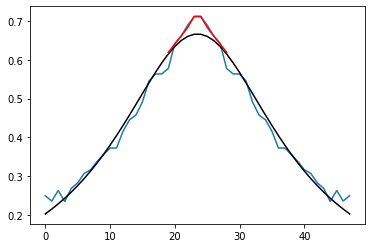

In [9]:
##### Trying Lorentzian Fit ######

def lorentzian( x, a, x0, gam ):
    return  a * gam**2 / ( gam**2 + ( x - x0 )**2)

a0 = np.copy(acf_zero)
a = np.copy(acf)
a1d = np.copy(acf1d)

##### The first Lorentzian fit ######

ydata = a

x = np.arange(0,len(ydata))

a_guess = np.max(ydata)
x0_guess = int(len(ydata)/2)
gam_guess = int(len(ydata)/4)

pguess = [a_guess, x0_guess, gam_guess]
print(pguess)
popt, pcov = curve_fit(lorentzian, x, ydata, p0 = np.array(pguess))

amp, x0, gam = popt[0], popt[1], popt[2]
print(amp, x0, gam)

yfit = lorentzian(x,amp,x0, gam)

plt.plot(ydata)
plt.plot(x, lorentzian(x,amp,x0, gam), 'k')
#plt.show()

#### Fitting the second Lorentzian #######

yleft = ydata - lorentzian(x,amp,x0, gam)
yleft=yleft[int(x0-gam/4):int(x0+gam/4)]


if len(yleft) <= 2:
    print("Nothing to fit here")

x2 = np.arange(0,len(yleft))

a_guess2 = np.max(yleft)
x0_guess2 = int(len(yleft)/2)
gam_guess2 = int(len(yleft)/4)

pguess2 = [a_guess2, x0_guess2, gam_guess2]
print(pguess2)
popt2, pcov2 = curve_fit(lorentzian, x2, yleft, p0 = np.array(pguess2))

amp2, x02, gam2 = popt2[0], popt2[1], popt2[2]
print(amp2, x02, gam2)

lor_combine = lorentzian(x,amp,x0, gam)+lorentzian(x,amp2,x0, gam2)



# plt.plot(ydata)
# plt.plot(x, lorentzian(x,amp,x0, gam), 'k:')
plt.plot(x[int(x0-3*gam2):int(x0+3*gam2)+2],lor_combine[int(x0-3*gam2):int(x0+3*gam2)+2], 'r')



####### Here Gamma is 1.31 samples that means a structure as narrow as 53.6 microseconds ######



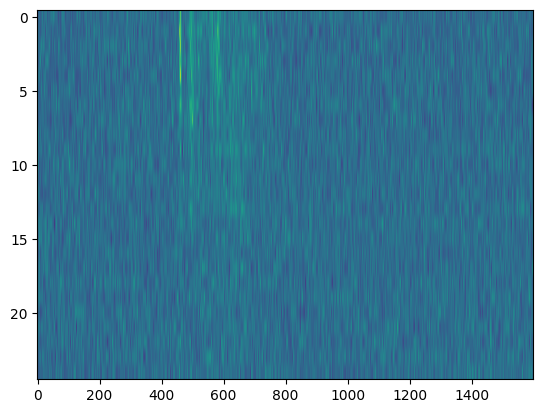

Downsample in micro sec 20.48


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 326/326 [00:00<00:00, 16640.42it/s]


40
326.0
[0.43035613959185287, 40, 20]
0.2974827967049431 39.50000010898732 94.18538489357515
(80,) (80,)
0.5295901439378284
[0.13288172633695466, 9, 4]
0.14155201801259096 9.527081968310249 2.7357824848904846
Microstructures/Microstruc_69841193.pdf


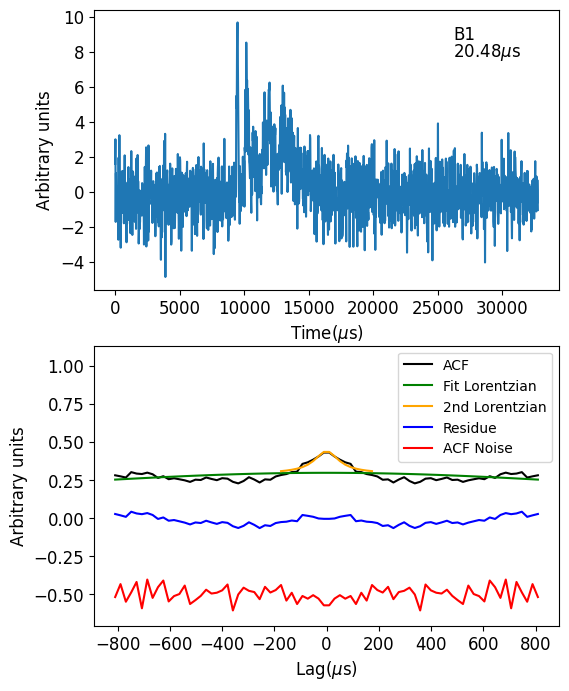

In [20]:
##### Testing on R4 event ########

def three_lorentzian(x,amp,amp2,x0,gam,gam2):
    lor_combine = lorentzian(x,amp,x0, gam)+lorentzian(x,amp2,x0, gam2)
    return lor_combine

file = '/data/user-data/ksand/baseband-analysis/playground/R4_69841193_dsamp_8.npz'

i=0

data_npz = np.load(file, allow_pickle = True)

data = data_npz['data_full']

t_scrunch = 1
f_scrunch = 16
data = scrunch_npy(data, f_scrunch=f_scrunch, t_scrunch=t_scrunch)
data = data[0:25,:]

plt.imshow(data, aspect="auto")
plt.show()

ds = 8
e = 69841193
print("Downsample in micro sec", ds*2.56)
# ts = data.sum(0)
# acf_zero = autocorr(ts, zerolag=True)
# acf = autocorr(ts, zerolag=False)
# acf1d = sig.correlate(ts, ts)
# acf1d = acf1d/np.max(acf1d)
# acf1d = acf1d[int(len(acf1d)/2):]
# #plot_acf(acf, acf1d, ts, acf_zero, e, ds)

# ###### Getting the full acf by flipping and adding ########

# acf = add_flip(acf)
# acf_zero  = add_flip(acf_zero)
# acf1d = add_flip(acf1d)

# ##### To get the acf near the peak #####

# nsamp = int(len(ts)/25)

# acf = acf[int(len(acf)/2)-nsamp:int(len(acf)/2)+nsamp]
# acf1d = acf1d[int(len(acf1d)/2)-nsamp:int(len(acf1d)/2)+nsamp]
# acf_zero = acf_zero[int(len(acf_zero)/2)-nsamp:int(len(acf_zero)/2)+nsamp]

# ##### Plotting #########

# #plot_acf(acf, acf1d, ts, acf_zero, e, ds, True)

# ####### Noise ACF ######
# peaks, widths, snrs = find_burst(ts, max_width=8192)
# if (peaks+widths) < len(ts) and (peaks-widths) > 0:
#     start_noise = 0
#     end_noise = int(peaks - widths)
# else:
#     print("Burst too wide can't find noise")

# ts_noise = ts[start_noise:end_noise]
# acf_zero_noise = autocorr(ts_noise, zerolag=True)
# acf_noise = autocorr(ts_noise, zerolag=False)
# acf1d_noise = sig.correlate(ts_noise, ts_noise)
# acf1d_noise = acf1d_noise/np.max(acf1d_noise)
# acf1d_noise = acf1d_noise[int(len(acf1d_noise)/2):]
# #plot_acf(acf, acf1d, ts, acf_zero, e, ds)

# ###### Getting the full acf by flipping and adding ########

# acf_noise = add_flip(acf_noise)
# acf_zero_noise  = add_flip(acf_zero_noise)
# acf1d_noise = add_flip(acf1d_noise)

# ###### Making the noise acf same size as burst acf ########

# nsamp = int(len(acf)/2)
# print(nsamp)
# print(len(acf_noise)/2)
# acf_noise = acf_noise[int(len(acf_noise)/2)-nsamp:int(len(acf_noise)/2)+nsamp]
# acf1d_noise = acf1d_noise[int(len(acf1d_noise)/2)-nsamp:int(len(acf1d_noise)/2)+nsamp]
# acf_zero_noise = acf_zero_noise[int(len(acf_zero_noise)/2)-nsamp:int(len(acf_zero_noise)/2)+nsamp]

# #plot_acf(acf_noise, acf1d_noise, ts_noise, acf_zero_noise, e, ds, True)

# ##### Adding Lorentzian #####

# ydata = acf

# x = np.arange(0,len(ydata))

# a_guess = np.max(ydata)
# x0_guess = int(len(ydata)/2)
# gam_guess = int(len(ydata)/4)

# pguess = [a_guess, x0_guess, gam_guess]
# print(pguess)
# popt, pcov = curve_fit(lorentzian, x, ydata, p0 = np.array(pguess))

# amp, x0, gam = popt[0], popt[1], popt[2]
# print(amp, x0, gam)

# yfit = lorentzian(x,amp,x0, gam)


# a1_guess = np.max(ydata)
# x0_guessd = int(len(ydata)/2)
# gam1_guess = int(len(ydata)/4)  
# a2_guess = np.max(ydata)/10
# gam2_guess = gam1_guess/10

# pguessd = [a1_guess, a2_guess, x0_guessd, gam1_guess, gam2_guess]
# print(pguessd)
# poptd, pcovd = curve_fit(two_lorentzian, x, ydata, p0 = np.array(pguessd))

# amp1,amp2,x0d,gam1,gam2 = poptd[0], poptd[1], poptd[2], poptd[3], poptd[4]


# y_double_fit = two_lorentzian(x,amp1,amp2,x0d,gam1,gam2)

# chi2 =  chi_sq(ydata,y_double_fit) 
# num_para2 = len(pguessd)
# num_obs2 = len(ydata)
# print(chi2)





# fig, ax = plt.subplots(2, figsize = (6,8))

# t_res = ds * 2.56
# xp = t_res*np.arange(acf.size)
# xp = xp - np.median(xp)
# xts = t_res*np.arange(ts.size)



# ax[0].plot(xts, ts)
# ax[0].set_xlabel(r"Time($\mu$s)", fontsize=12)
# ax[0].set_ylabel("Arbitrary units", fontsize=12)
# ax[0].text(np.max(xts)-np.max(xts)/5,np.max(ts)-np.max(ts)/10, 'B'+str(int(i/3)+1), fontsize=12)#### Replaced with B number##
# ax[0].text(np.max(xts)-np.max(xts)/5,np.max(ts)-2*np.max(ts)/10, str(t_res)+r"$\mu$s", fontsize=12)
# ax[0].tick_params(axis='both', which='major', labelsize=12)


# ax[1].plot(xp, acf, color='k', label='ACF')
# #ax[1].plot(xp, lorentzian(x,amp,x0, gam), 'g', label="Fit Lorentzian")
# ax[1].plot(xp, y_double_fit, 'orange')
# ax[1].plot(xp,acf - y_double_fit, 'b', label="Residue")
# ax[1].plot(xp,acf_noise-0.5, color='r', label="ACF Noise")
# ax[1].set_xlabel(r"Lag($\mu$s)", fontsize=12)
# ax[1].set_ylabel("Arbitrary units", fontsize=12)
# ax[1].legend(loc="upper right")
# ax[1].set_ylim(np.min(acf_noise-0.5)-0.1,np.max(acf)+0.7)
# ax[1].tick_params(axis='both', which='major', labelsize=12)
# oname = "Microstructures/Microstruc_{}.pdf".format(e)
# print(oname)
# #plt.savefig(oname, dpi = 300, bbox_inches = 'tight')
# plt.show()


ts = data.sum(0)
acf_zero = autocorr(ts, zerolag=True)
acf = autocorr(ts, zerolag=False)
acf1d = sig.correlate(ts, ts)
acf1d = acf1d/np.max(acf1d)
acf1d = acf1d[int(len(acf1d)/2):]
#plot_acf(acf, acf1d, ts, acf_zero, e, ds)

###### Getting the full acf by flipping and adding ########

acf = add_flip(acf)
acf_zero  = add_flip(acf_zero)
acf1d = add_flip(acf1d)

##### To get the acf near the peak #####

nsamp = int(len(ts)/40)

acf = acf[int(len(acf)/2)-nsamp:int(len(acf)/2)+nsamp]
acf1d = acf1d[int(len(acf1d)/2)-nsamp:int(len(acf1d)/2)+nsamp]
acf_zero = acf_zero[int(len(acf_zero)/2)-nsamp:int(len(acf_zero)/2)+nsamp]

##### Plotting #########

#plot_acf(acf, acf1d, ts, acf_zero, e, ds, True)

####### Noise ACF ######
peaks, widths, snrs = find_burst(ts, max_width=8192)
if (peaks+widths) < len(ts) and (peaks-widths) > 0:
    start_noise = 0
    end_noise = int(peaks - widths)
else:
    print("Burst too wide can't find noise")

ts_noise = ts[start_noise:end_noise]
acf_zero_noise = autocorr(ts_noise, zerolag=True)
acf_noise = autocorr(ts_noise, zerolag=False)
acf1d_noise = sig.correlate(ts_noise, ts_noise)
acf1d_noise = acf1d_noise/np.max(acf1d_noise)
acf1d_noise = acf1d_noise[int(len(acf1d_noise)/2):]
#plot_acf(acf, acf1d, ts, acf_zero, e, ds)

###### Getting the full acf by flipping and adding ########

acf_noise = add_flip(acf_noise)
acf_zero_noise  = add_flip(acf_zero_noise)
acf1d_noise = add_flip(acf1d_noise)

###### Making the noise acf same size as burst acf ########

nsamp = int(len(acf)/2)
print(nsamp)
print(len(acf_noise)/2)
acf_noise = acf_noise[int(len(acf_noise)/2)-nsamp:int(len(acf_noise)/2)+nsamp]
acf1d_noise = acf1d_noise[int(len(acf1d_noise)/2)-nsamp:int(len(acf1d_noise)/2)+nsamp]
acf_zero_noise = acf_zero_noise[int(len(acf_zero_noise)/2)-nsamp:int(len(acf_zero_noise)/2)+nsamp]

#plot_acf(acf_noise, acf1d_noise, ts_noise, acf_zero_noise, e, ds, True)

##### Adding Lorentzian #####

ydata = acf

x = np.arange(0,len(ydata))

a_guess = np.max(ydata)
x0_guess = int(len(ydata)/2)
gam_guess = int(len(ydata)/4)

pguess = [a_guess, x0_guess, gam_guess]
print(pguess)
popt, pcov = curve_fit(lorentzian, x, ydata, p0 = np.array(pguess))

amp, x0, gam = popt[0], popt[1], popt[2]
print(amp, x0, gam)

yfit = lorentzian(x,amp,x0, gam)

print(ydata.shape, yfit.shape)

chi1 =  chi_sq(ydata,yfit) 
num_para1 = len(pguess)
num_obs1 = len(ydata)
print(chi1)

### Second Lorentzian #####

if e == 69841193:

    yleft = ydata - yfit
    yleft=yleft[int(x0-gam/10):int(x0+gam/10)]


    if len(yleft) <= 2:
        print("Nothing to fit here")

    x2 = np.arange(0,len(yleft))

    a_guess2 = np.max(yleft)
    x0_guess2 = int(len(yleft)/2)
    gam_guess2 = int(len(yleft)/4)

    pguess2 = [a_guess2, x0_guess2, gam_guess2]
    print(pguess2)
    popt2, pcov2 = curve_fit(lorentzian, x2, yleft, p0 = np.array(pguess2))

    amp2, x02, gam2 = popt2[0], popt2[1], popt2[2]
    print(amp2, x02, gam2)

    lor_combine = lorentzian(x,amp,x0, gam)+lorentzian(x,amp2,x0, gam2)



fig, ax = plt.subplots(2, figsize = (6,8))

t_res = ds * 2.56
xp = t_res*np.arange(acf.size)
xp = xp - np.median(xp)
xts = t_res*np.arange(ts.size)



ax[0].plot(xts, ts)
ax[0].set_xlabel(r"Time($\mu$s)", fontsize=12)
ax[0].set_ylabel("Arbitrary units", fontsize=12)
ax[0].text(np.max(xts)-np.max(xts)/5,np.max(ts)-np.max(ts)/10, 'B'+str(int(i/3)+1), fontsize=12)#### Replaced with B number##
ax[0].text(np.max(xts)-np.max(xts)/5,np.max(ts)-2*np.max(ts)/10, str(t_res)+r"$\mu$s", fontsize=12)
ax[0].tick_params(axis='both', which='major', labelsize=12)


ax[1].plot(xp, acf, color='k', label='ACF')
ax[1].plot(xp, lorentzian(x,amp,x0, gam), 'g', label="Fit Lorentzian")
if e == 69841193:
    ax[1].plot(xp[int(x0-3*gam2):int(x0+3*gam2)+2],
               lor_combine[int(x0-3*gam2):int(x0+3*gam2)+2], 'orange', label='2nd Lorentzian')
    ax[1].plot(xp,acf - lor_combine, 'b', label="Residue")
else:
    ax[1].plot(xp,acf - lorentzian(x,amp,x0, gam), 'b', label="Residue")
ax[1].plot(xp,acf_noise-0.5, color='r', label="ACF Noise")
ax[1].set_xlabel(r"Lag($\mu$s)", fontsize=12)
ax[1].set_ylabel("Arbitrary units", fontsize=12)
ax[1].legend(loc="upper right")
ax[1].set_ylim(np.min(acf_noise-0.5)-0.1,np.max(acf)+0.7)
ax[1].tick_params(axis='both', which='major', labelsize=12)
oname = "Microstructures/Microstruc_{}.pdf".format(e)
print(oname)
#plt.savefig(oname, dpi = 300, bbox_inches = 'tight')
plt.show()



23891929
206 78 62.14544183510553
16
Microstructures/Microstruc_23891929_v2.jpeg
92773515
125 25 13.231305455062186
32
Microstructures/Microstruc_92773515_v2.jpeg
176060009
512 191 53.04995211076828
1
Microstructures/Microstruc_176060009_v2.jpeg
194488454
485 138 43.124324881338644
4
Microstructures/Microstruc_194488454_v2.jpeg
40363753
272 99 90.15345084659592
16
Microstructures/Microstruc_40363753_v2.jpeg
203935225
766 240 137.63983140406194
8
Microstructures/Microstruc_203935225_v2.jpeg
194488393
1661 529 182.3787332447644
4
Microstructures/Microstruc_194488393_v2.jpeg
92844954
235 89 71.79541076807713
16
Microstructures/Microstruc_92844954_v2.jpeg
23789294
124 44 35.252993669904114
32
Microstructures/Microstruc_23789294_v2.jpeg
166812476
127 31 62.479077406475035
32
Microstructures/Microstruc_166812476_v2.jpeg


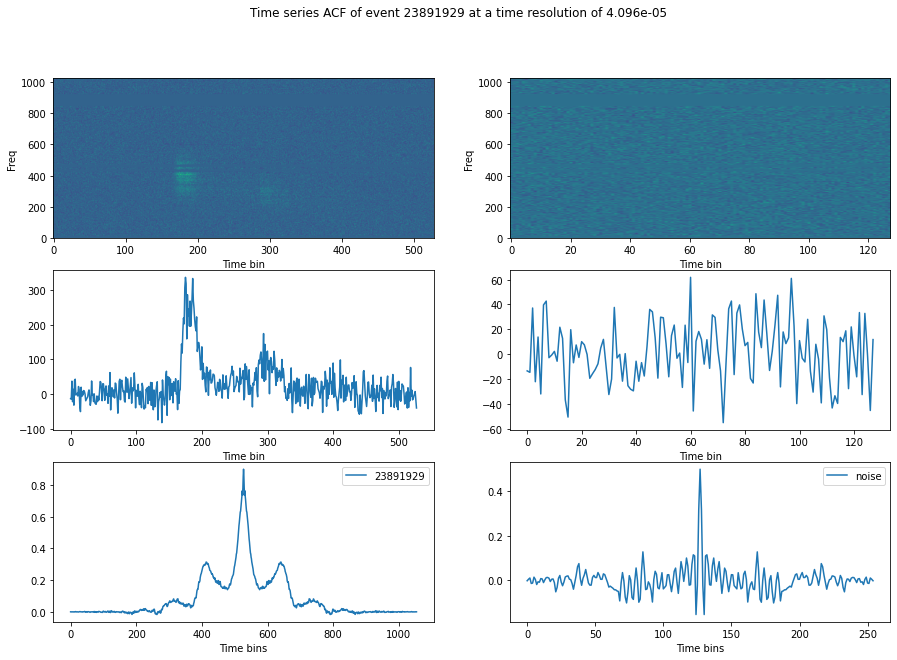

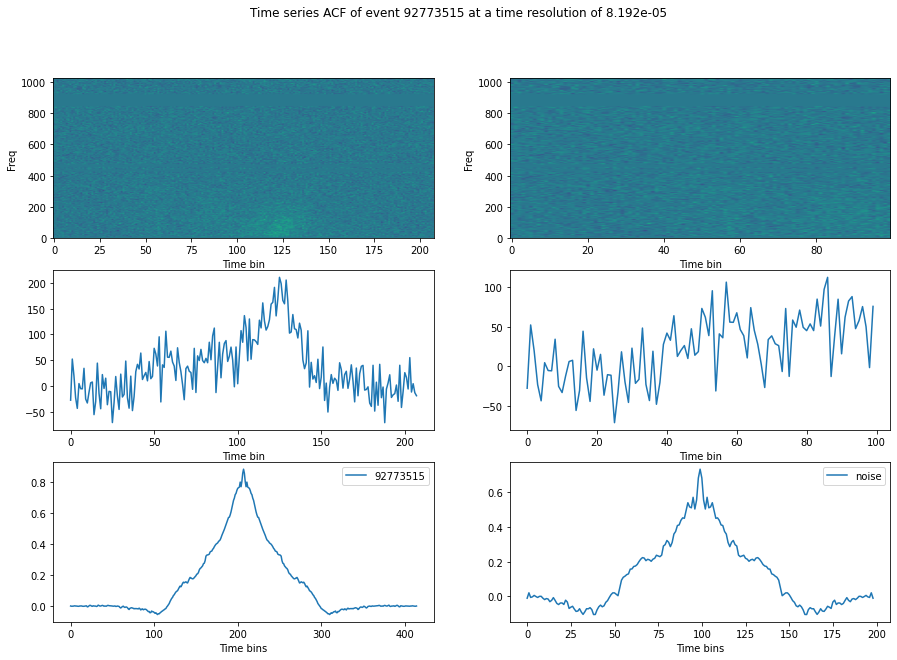

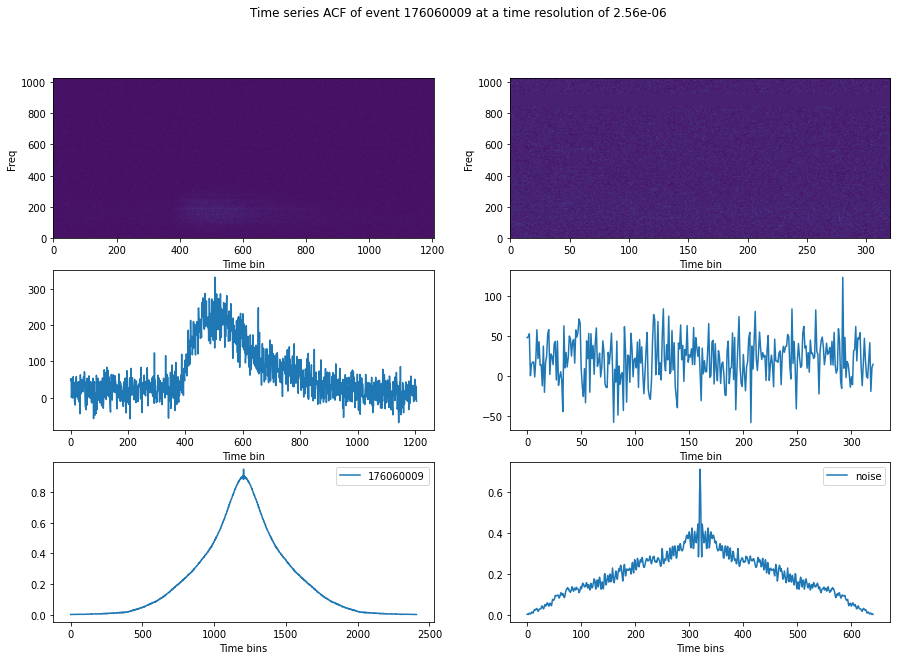

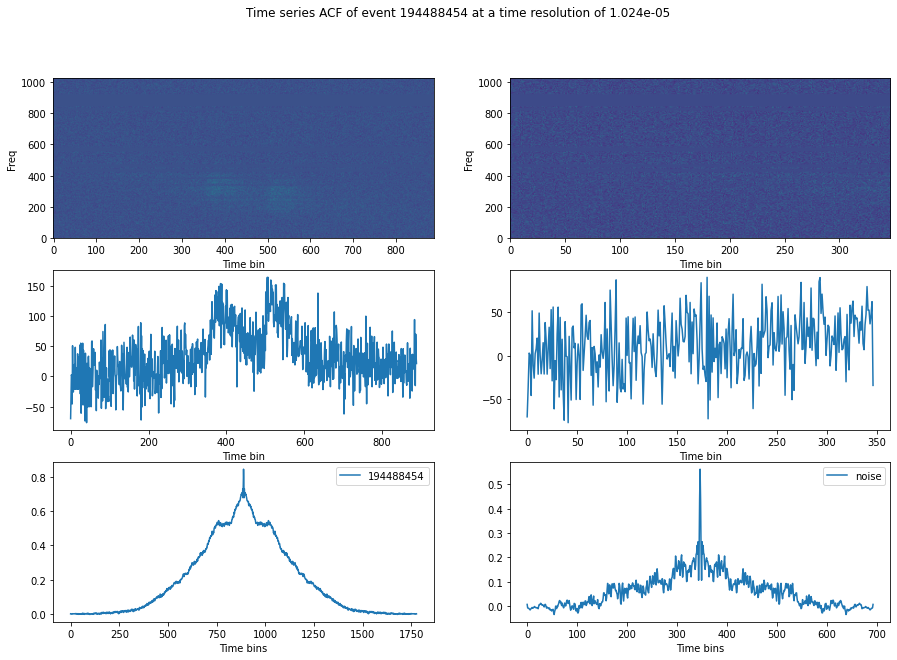

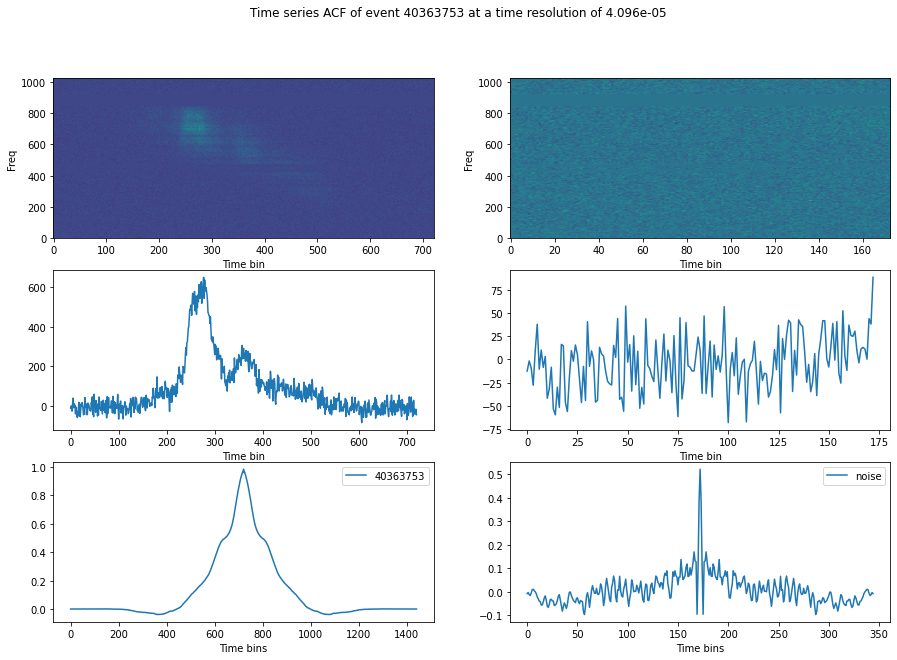

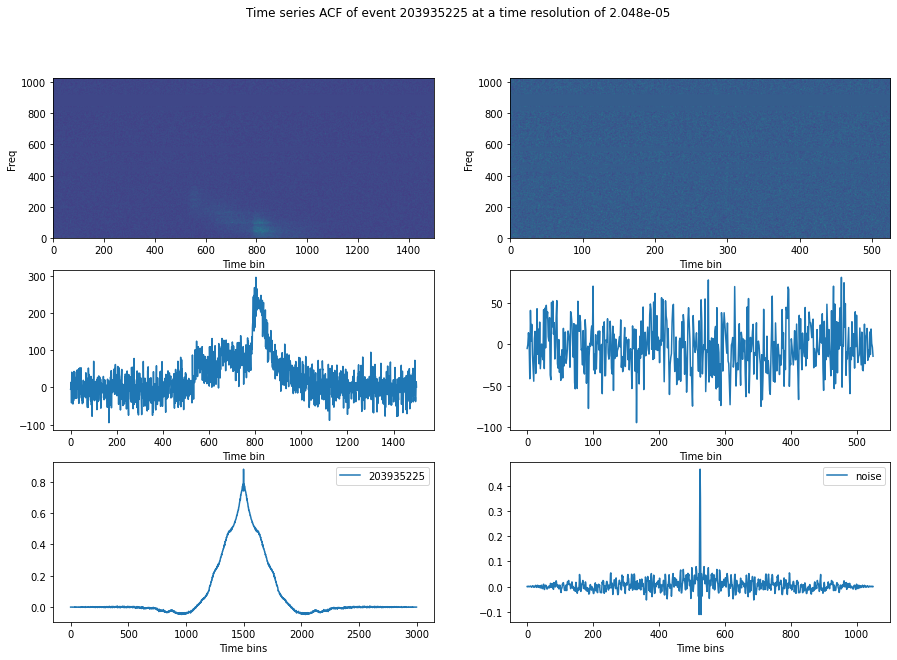

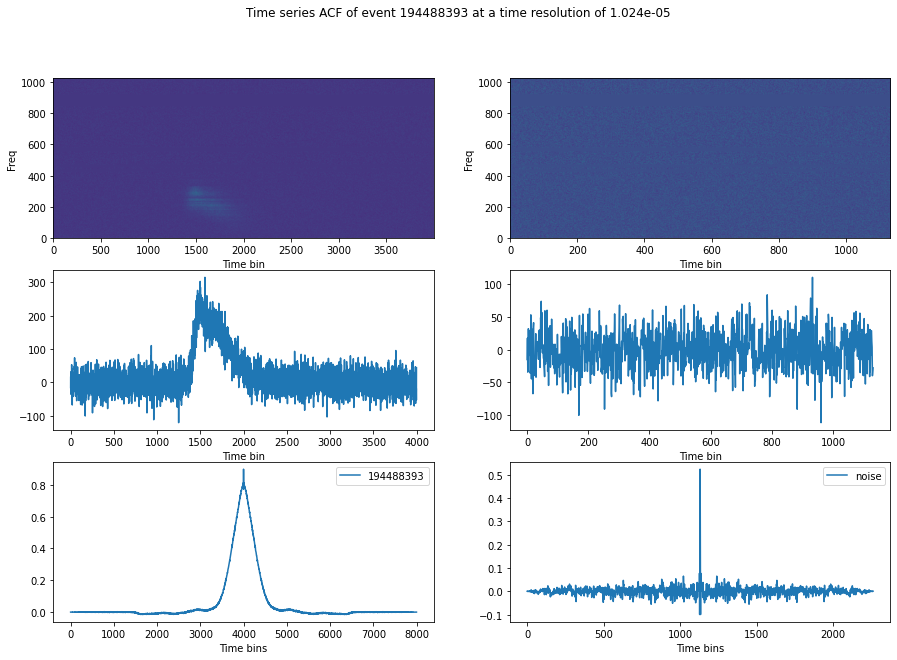

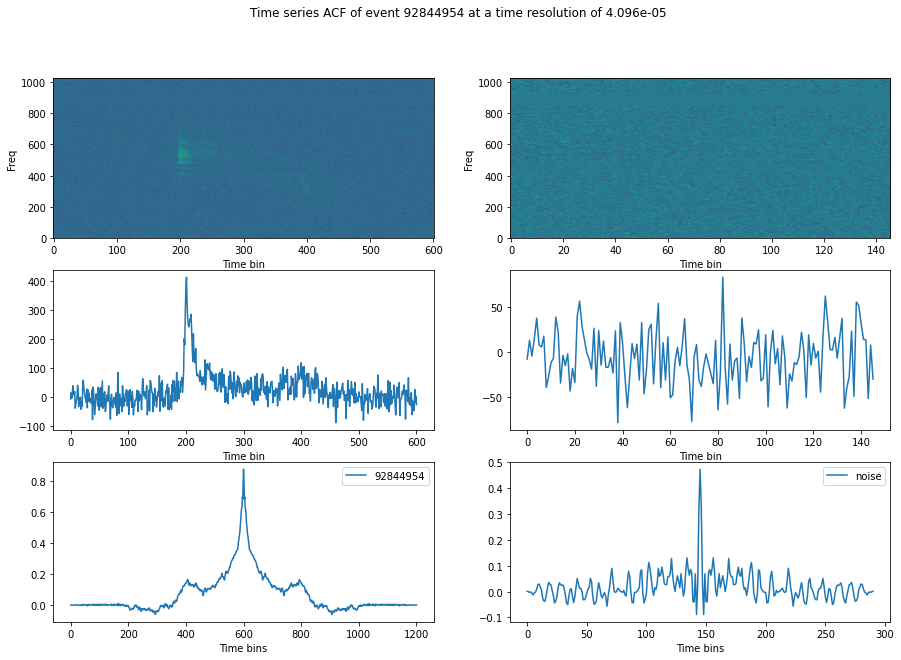

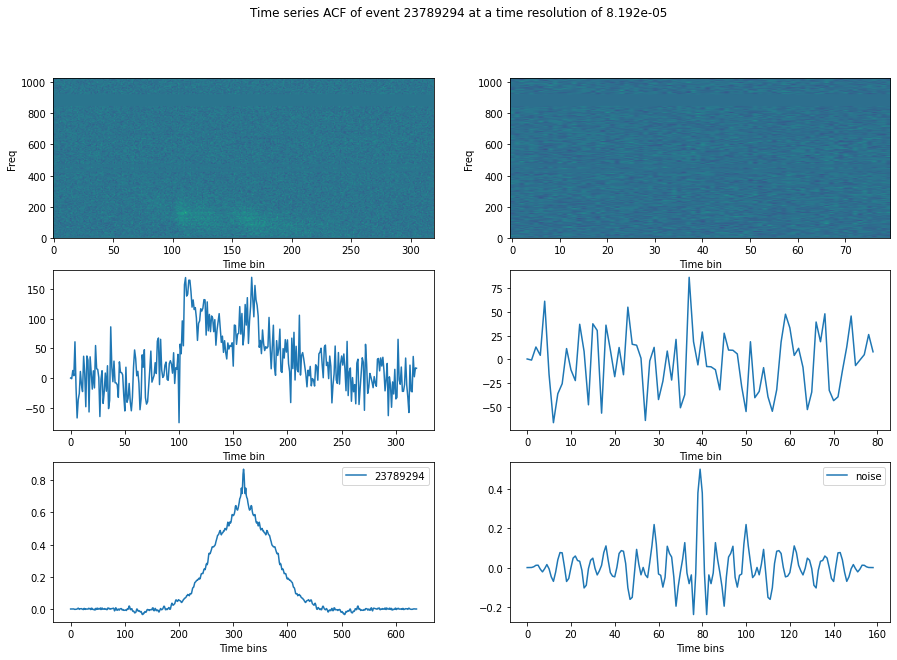

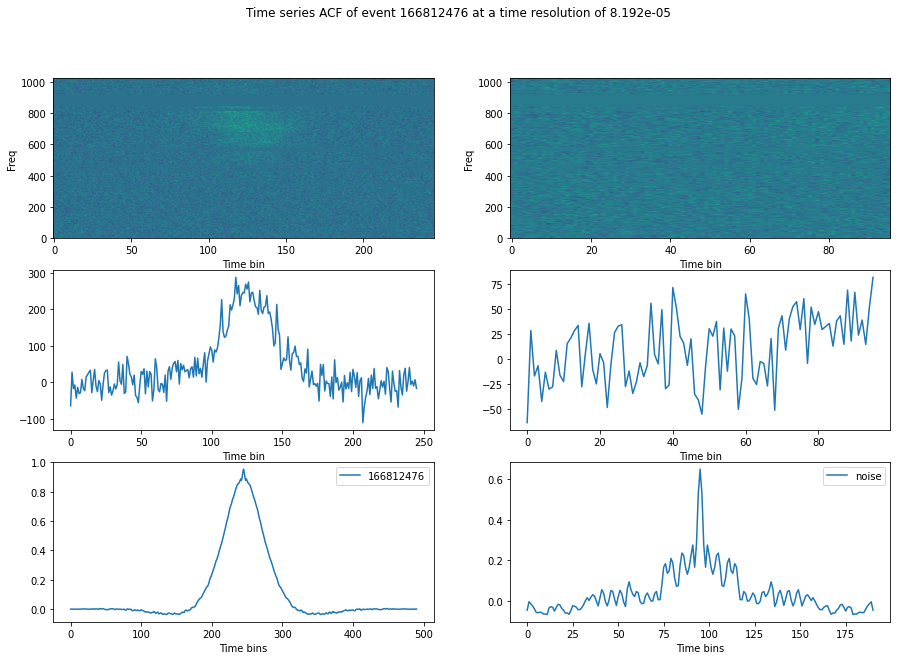

In [8]:
import gc
#event_id = '67522901', '69509443'
# event_id = '69509443'
#event_id = 40363753
x = []
for i in range(0,len(npz_files),3):
    if npz_files[i] != '71785167':
        if npz_files[i+2] < 64: 
        #if npz_files[i] == event_id:
            e = npz_files[i]
            print(e)
            acf_npy = npz_files[i+1]
            #print(acf_npy)
    #         plt.imshow(acf_npy, aspect = 'auto')
    #         plt.show()
            peaks, widths, snrs = find_burst(acf_npy.sum(0), max_width=8192)
            print(peaks, widths, snrs)
        #     hifreq = 511.828
        #     lofreq = 400.000
        #     fres = 400/1024#(hifreq - lofreq) / acf_npy.shape[0]
        #     tres = 32*2.56e-6#(tw) / acf_npy.shape[1]
            #acf_npy = acf_npy[:, peaks-widths:peaks+widths]
    #         plt.imshow(acf_npy, aspect = 'auto')
    #         plt.show()
            fs = acf_npy.sum(1)
            ts = acf_npy.sum(0)

            if (peaks+widths) < len(ts) and (peaks-widths) > 0:
                start_noise = 0
                end_noise = int(peaks - widths)
            else:
                print("Burst too wide can't find noise")
            acf_npy_noise = acf_npy[:,start_noise:end_noise]
    #         plt.imshow(acf_npy_noise, aspect = 'auto')
    #         plt.show()

            ts_n = acf_npy_noise.sum(0)
    #         plt.plot(ts_n)
    #         plt.show()

            acf1d_noise = sig.correlate(ts_n, ts_n)
            acf1d_noise = acf1d_noise / np.max(acf1d_noise)
    #         plt.plot(acf1d_noise, label='noise')
    #         plt.legend
    #         plt.show()

            acf1dsav_noise = sig.savgol_filter(acf1d_noise, 11, 7)
    #         plt.plot(acf1dsav_noise/np.max(acf1dsav_noise))
    #         plt.show()


        #     plt.imshow(acf_npy, aspect = 'auto')
        #     plt.show()

    #         plt.plot(fs)
    #         plt.show()
    #         print(ts.shape)
    #         plt.plot(ts)
    #         plt.show()

            #ts2 = ts[0:500]

            acf1d = sig.correlate(ts, ts)
            acf1d = acf1d / np.max(acf1d)
        #     acf1d_noise = sig.correlate(ts2, ts2)
        #     acf1d_noise = acf1d_noise / np.max(acf1d_noise)
        #     plt.plot(acf1d_noise)
        #     plt.show()
            #acf1d[np.where(acf1d == np.max(acf1d))[0][0]] = np.sort(acf1d)[-2]
            acf1dsav = sig.savgol_filter(acf1d, 11, 7)
        #     acf1dsav_noise = sig.savgol_filter(acf1d_noise, 59, 7)
        #     plt.plot(acf1dsav_noise/np.max(acf1dsav_noise))
        #     plt.show()
            




    #         plt.plot(acf1d, label=e)
    #         plt.legend()
    #         #plt.xlim(len(acf1d)//2-200, len(acf1d)//2 + 4000)
    #         plt.show()

            #acf1dsav = acf1dsav/np.max(acf1dsav)
    #         plt.plot(acf1dsav)
    #         plt.show()
            x.append(acf1d)
            x.append(acf1dsav)

            ds = npz_files[i+2]
            print(ds)
            t_res = ds * 2.56e-6

            fig, ax = plt.subplots(3, 2, figsize = (15,10))


            fig.suptitle("Time series ACF of event {} at a time resolution of {}".format(e,t_res))

            ax[0][0].imshow(acf_npy, aspect='auto', origin='lower')
            ax[0][0].set_xlabel("Time bin")
            ax[0][0].set_ylabel("Freq")
            ax[0][1].imshow(acf_npy_noise, aspect='auto',origin='lower')
            ax[0][1].set_xlabel("Time bin")
            ax[0][1].set_ylabel("Freq")

            ax[1][0].plot(ts)
            ax[1][0].set_xlabel("Time bin")
            ax[1][1].plot(ts_n)
            ax[1][1].set_xlabel("Time bin")

            ax[2][0].plot(acf1dsav, label = e)
            ax[2][0].legend()
            ax[2][0].set_xlabel("Time bins")
            ax[2][1].plot(acf1dsav_noise, label='noise')
            ax[2][1].legend()
            ax[2][1].set_xlabel("Time bins")

            oname = "Microstructures/Microstruc_{}_v2.jpeg".format(e)
            print(oname)
            plt.savefig(oname, dpi = 300, bbox_inches = 'tight')

            fig.show()
            gc.collect()
        #plt.xlim(len(acf1d)//2-4000, len(acf1d)//2 + 4000)

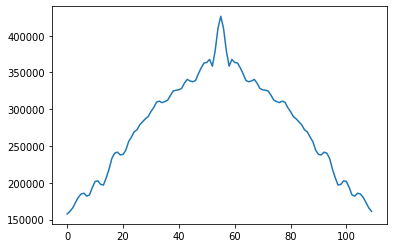

46.55375499438919 13117.450918656219


/root/.local/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [84]:
def lorentzian( x, x0, gam ):
    return  0.78 * gam**2 / ( gam**2 + ( x - x0 )**2)

def lorentzian2( x, a, x0, gam ):
    return  a * gam**2 / ( gam**2 + ( x - x0 )**2)
ydata = x[1]
#ydata = ydata[800:860]


xdata = np.arange(len(ydata))

plt.plot(ydata[40:150])
plt.show()

xdata = xdata[40:150]
ydata = ydata[40:150]

# # xdata = xdata[5000:8600]
# # ydata = ydata[5000:8600]

a_guess = 35000 
x0_guess = 95
gam_guess = 40

pguess = [x0_guess, gam_guess]
popt, pcov = curve_fit(lorentzian, xdata, ydata, p0 = pguess)
x0, gam = popt[0], popt[1]

print(x0, gam)


# yleft = ydata - lorentzian(xdata,x0, gam)


# x1_guess = 6800
# gam1_guess = 20
# a1_guess = 1

# p1guess = [a1_guess, x1_guess, gam1_guess]
# popt1, pcov1 = curve_fit(lorentzian2, xdata, yleft, p0 = p1guess, bounds = (0,[1, 7000, 100]))
# a1, x1, gam1 = popt1[0], popt1[1], popt1[2]

# print(a1,x1,gam1)
# # xdata = xdata[4200:9200]
# # ydata = ydata[4200:9200]

# ycomb = lorentzian(xdata,x0, gam) + lorentzian2(xdata, a1, x1, gam1)
# dt = 4

# labs = []
# x_ticks = np.arange(x0-(len(xdata)/2), x0+(len(xdata)/2), 100)
# #x_ticks = xdata - x0
# # #print(x_ticks)
# # # for i in range(len(x_ticks)):
# # #     labs.append(str(x_ticks[i]))
# # #labs = str(x_ticks)
# # #print(labs)
# # ticksy = np.arange(min(xdata), max(xdata), 200.0)
# # xticksy = np.arange(min(x_ticks), max(x_ticks), 200.0)
# for i in range(len(x_ticks)):
#     labs.append(str(int(x_ticks[i]-x0)))


# plt.figure(figsize=(10,6))
# #print(np.array_str(ticksy))
# plt.xticks(ticks = x_ticks, labels = labs, fontsize=14)
# plt.yticks(fontsize=14)
# plt.plot(xdata, ydata, color = 'deepskyblue',label="ACF")
# plt.plot(xdata, lorentzian(xdata,x0, gam), 'k:')
# plt.text(6850, 0.95, 'Width full = %5.2f us' % (dt * gam), fontsize = 15)
# plt.text(6850, 0.90, 'Width substructure = %5.2f us' % (dt * gam1), fontsize = 15)
# #plt.plot(xdata, ydata - lorentzian(xdata,x0, gam) + 0.4  , 'r')
# #plt.plot(xdata, lorentzian2(xdata, a1, x1, gam1) + 0.89 , 'g')
# plt.ylabel("ACF", fontsize=15)
# plt.xlim(6300,7310)
# plt.plot(xdata, ycomb, 'brown',label="Lorentzian")
# plt.legend(loc='upper left' ,fontsize=15)
# oname = "Lorentzian.jpg"
# plt.savefig(oname, bbox_inches='tight', dpi=300)

In [ ]:
tw = 83.33333 #seconds
fscr = 32 #freq scrunch factor
tscr = 1 #time scrunch factor
bw = 375
cfreq = 801.46484375 #center freq
hifreq = 988.96484375 #upper lim freq
lofreq = 613.96484375 #lower lim freq

acf_npy = sub_npy('GBT_F_highres_4.069333333333329e-06.npy', f_scrunch=fscr, t_scrunch=tscr)
acf_npy = acf_npy[47:52,:]
peaks, widths, snrs = find_burst(acf_npy.sum(0), max_width=4096)
fres = (hifreq - lofreq) / acf_npy.shape[0]
tres = (tw) / acf_npy.shape[1]
acf_npy = acf_npy[:, peaks-widths:peaks+widths]
fs = acf_npy.sum(1)
ts = acf_npy.sum(0)

plt.imshow(acf_npy, aspect = 'auto')
plt.show()

plt.plot(fs)
plt.show()

plt.plot(ts)
plt.show()

acf1d = sig.correlate(ts, ts)
#acf1d[np.where(acf1d == np.max(acf1d))[0][0]] = np.sort(acf1d)[-2]
acf1dsav = sig.savgol_filter(acf1d, 59, 7)
acf1d = acf1d / np.max(acf1d)

plt.plot(acf1d)
#plt.xlim(len(acf1d)//2-200, len(acf1d)//2 + 4000)
plt.show()

plt.plot(acf1dsav / np.max(acf1dsav))
#plt.xlim(len(acf1d)//2-4000, len(acf1d)//2 + 4000)
plt.show()

In [123]:
import pyne2001

ModuleNotFoundError: No module named 'pyne2001'